In [2]:
import pandas as pd
import numpy as np
import os

from cornac.eval_methods.ratio_split import RatioSplit
from cornac.data.modality import FeatureModality
from cornac.metrics import RMSE, MAE, Precision, Recall, AUC, NDCG, FMeasure
from cornac import Experiment
from cornac.datasets.goodreads import prepare_data
from recommenders.datasets.pandas_df_utils import LibffmConverter

from cornac.models.fm_py import FMRec
from cornac.explainer.limers import LimeRSExplainer
from cornac.utils.libffm_mod import LibffmModConverter

/Users/yyz/Desktop/2023-explainable-recommendations/my_venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


FM model is only supported on Linux.
Windows executable can be found at http://www.libfm.org.


In [75]:
fpath_genres = '../cornac/datasets/good_reads/goodreads_genres.csv'
fpath_aspects = '../cornac/datasets/good_reads/uid_aspect_features.txt'
genres = pd.read_csv(fpath_genres)
user_aspects = pd.read_csv(fpath_aspects, sep='\t', usecols=['user_id', 'feature'])

In [3]:
rs = prepare_data(data_name="goodreads_limers", test_size=0.2, dense=False, item=True, user=False, sample_size=0.5, seed=21)

# print("item feature: genre")
# print(rs.train_set.item_feature.features)
# print("\n user feature: aspect from review")
# print(rs.train_set.user_feature.features)

**FM and LIMERS** 

Let's first illustrate the inputs required for model FM:
- For FM: uir and feature are joined on 'item_id' or 'user_id'; it then gets transformed to one-hot encoded df to feed into pylibfm.FM

In [4]:
fm = FMRec()
#fm.fit(train_set = rs.train_set)

In [7]:
print("set of item features:")
print(set(fm.train_set.item_features['feature']))
print("\n set of user features:")
print(set(fm.train_set.user_features['feature']))

set of item features:
{'crime', 'graphic', 'history', 'children', 'fiction', 'thriller', 'biography', 'poetry', 'mystery', 'historical-fiction', 'fantasy', 'comics', 'paranormal', 'young-adult', 'romance', 'non-fiction'}

 set of user features:
{'storytimes', 'story', 'writer', 'mystery', 'groups', 'thing', 'boyfriend', 'people', 'side', 'connection', 'hair', 'person', 'moments', 'multitaskingmomma', 'scene', 'subject', 'verdict', 'language', 'disclosure', 'category', 'nature', 'father', 'ending', 'lady', 'family', 'text', 'men', 'suspense', 'elements', 'job', 'lot', 'plot', 'artwork', 'starter', 'chapter', 'stuff', 'writing', 'fight', 'errors', 'flowers', 'message', 'readers', 'animals', 'panties', 'confrontation', 'scenes', 'century', 'publisher', 'issues', 'fiction', 'things', 'guys', 'goodreads', 'share', 'copy', 'imagery', 'women', 'bloopers', 'friends', 'bit', 'version', 'society', 'thriller', 'stars', 'movie', 'grade', 'ages', 'title', 'sister', 'run', 'thanks', 'twist', 'scenar

In [8]:
#input required for FM
item_features_long, _= fm.train_set.convert_to_feature_long()
df = pd.merge(fm.train_set.training_df, item_features_long,on="item_id",how="left",)
df_ohe = pd.get_dummies(df)
df_ohe #can also include all column names as well

,biography,children,comics,crime,fantasy,fiction,graphic,historical-fiction,history,mystery,...,item_id_990,item_id_991,item_id_992,item_id_993,item_id_994,item_id_995,item_id_996,item_id_997,item_id_998,item_id_999
0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10182,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
10183,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
10184,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
10185,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
metric = [RMSE(), MAE(), FMeasure(k=20), AUC(), NDCG(k=50)]
Experiment(eval_method=rs, models=[fm],metrics=metric).run()

Creating validation dataset of 0.01 of training for adaptive regularization
-- Epoch 1
Training MSE: 0.79304
-- Epoch 2
Training MSE: 0.71636
-- Epoch 3
Training MSE: 0.68778
-- Epoch 4
Training MSE: 0.66468
-- Epoch 5
Training MSE: 0.64010
-- Epoch 6
Training MSE: 0.61647
-- Epoch 7
Training MSE: 0.59188
-- Epoch 8
Training MSE: 0.56720
-- Epoch 9
Training MSE: 0.54274
-- Epoch 10
Training MSE: 0.51926

TEST:
...
             |    MAE |   RMSE |    AUC |  F1@20 | NDCG@50 | Train (s) |   Test (s)
------------ + ------ + ------ + ------ + ------ + ------- + --------- + ----------
fm_regressor | 0.9269 | 0.9694 | 0.5447 | 0.0001 |  0.0005 |  595.7017 | 11157.9184



Now let's train FM model and make one explanation to a specific user

In [82]:
import random
user_id, user_idx = random.choice(list(rs.train_set.uid_map.items()))
user_id

'879d4548d46ff3334f4dd7e1b006d6b1'

In [83]:
explainer = LimeRSExplainer(fm, fm.train_set)
recommendations = fm.recommend([user_id], n=15)
explanation = explainer.explain_recommendations(recommendations)
explanation

Computing explanations: 100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


,user_id,item_id,explanations,local_prediction
0,879d4548d46ff3334f4dd7e1b006d6b1,19547578,"{'non-fiction': 0.358, 'fiction_i_f': 0.259, '...",4.838
0,879d4548d46ff3334f4dd7e1b006d6b1,12978996,"{'non-fiction': 0.28, 'fiction_i_f': 0.249, 'h...",4.521
0,879d4548d46ff3334f4dd7e1b006d6b1,6792310,"{'graphic': 0.126, 'comics': 0.126, 'non-ficti...",4.683
0,879d4548d46ff3334f4dd7e1b006d6b1,20949426,"{'fiction_i_f': 0.445, 'history_i_f': 0.171, '...",4.806
0,879d4548d46ff3334f4dd7e1b006d6b1,6678976,"{'fiction_i_f': 0.359, 'paranormal': -0.244, '...",3.914
0,879d4548d46ff3334f4dd7e1b006d6b1,10380634,"{'fiction_i_f': 0.367, 'history_i_f': 0.147, '...",4.766
0,879d4548d46ff3334f4dd7e1b006d6b1,6809532,"{'children_i_f': 0.397, 'fiction_i_f': 0.269, ...",4.384
0,879d4548d46ff3334f4dd7e1b006d6b1,1250914,"{'poetry': 0.333, 'non-fiction': 0.261, 'ficti...",5.038
0,879d4548d46ff3334f4dd7e1b006d6b1,557658,"{'non-fiction': 0.229, 'poetry': 0.205, 'ficti...",4.980
0,879d4548d46ff3334f4dd7e1b006d6b1,786269,"{'fiction_i_f': 0.403, 'paranormal': -0.152, '...",4.111


In [84]:
explanation['explanations'].iloc[0]

{'non-fiction': 0.358,
 'fiction_i_f': 0.259,
 'history_i_f': 0.073,
 'historical-fiction': 0.073,
 'biography': 0.073,
 'review': 0.0,
 'rating': 0.0,
 'characters': 0.0}

In [85]:
recommendations

,user_id,item_id,prediction
0,879d4548d46ff3334f4dd7e1b006d6b1,19547578,5.0
1,879d4548d46ff3334f4dd7e1b006d6b1,12978996,5.0
2,879d4548d46ff3334f4dd7e1b006d6b1,6792310,5.0
3,879d4548d46ff3334f4dd7e1b006d6b1,20949426,5.0
4,879d4548d46ff3334f4dd7e1b006d6b1,6678976,5.0
5,879d4548d46ff3334f4dd7e1b006d6b1,10380634,5.0
6,879d4548d46ff3334f4dd7e1b006d6b1,6809532,5.0
7,879d4548d46ff3334f4dd7e1b006d6b1,1250914,5.0
8,879d4548d46ff3334f4dd7e1b006d6b1,557658,5.0
9,879d4548d46ff3334f4dd7e1b006d6b1,786269,5.0


**Try to illustrate and explain LIMERS output**

We want to perform prediction on the test dataset:
1. Create a dataframe summary of the test data as df 
2. Filter one record from df to perform analysis:
   1. Select one record from df, namely uid, iid
   2. Look at the explanation provided by explainer for uid
   3. Filter all the items rated by uid in the training data and count # each genres are mentioned in these items
   4. Display explanation and genre frequencies in bar chart 

In [86]:
def test_data_summary(rs, model):
    # create a summary df with testdata 
    #   user_id, user_idx, item_id, item_idx, rating prediction, user and item frequency
    #   sorted by user frequency (how many different items this user has rated) and 
    #   difference of prediction and rating 
    
    test_data = [(x[0], y[0], z[0]) for (x, y, z) in rs.test_set.uir_iter()]
    predictions = [model.score(x, y) for (x,y,_) in test_data]

    user_id = list(rs.test_set.uid_map.keys())
    user_idx = list(rs.test_set.uid_map.values())
    item_id = list(rs.test_set.iid_map.keys())
    item_idx = list(rs.test_set.iid_map.values())
    test_user_id = [user_id[user_idx.index(x)] for (x,_,_) in test_data]
    test_item_id = [item_id[item_idx.index(y)] for (_,y,_) in test_data]

    df = pd.DataFrame(test_data, columns=['user_idx', 'item_idx', 'rating'])
    df['user_id'] = test_user_id
    df['item_id'] = test_item_id
    df['prediction'] = predictions
    df['abs_difference'] = abs(df['prediction'] - df['rating'])
    df = df.merge(pd.DataFrame(model.train_set.user_frequency, columns=['user_id', 'user_frequency']), how='left', on='user_id')
    df = df.merge(pd.DataFrame(model.train_set.item_frequency, columns=['item_id', 'item_frequency']), how='left', on='item_id')
    df = df.sort_values(by=['abs_difference'], ascending=True)
    df = df.sort_values(by=['item_frequency'], ascending=False)
    df = df.reset_index(drop=True)
    return df

In [87]:
def filter_one_explanation(rs, df, idx, explainer):
    user = df.iloc[idx].user_id
    item = df.iloc[idx].item_id
    #convert explanation to a dictionary
    explanation = explainer.explain_one_recommendation_to_user(user, item, num_features=10)
    # exp = explanation.explanations.to_list()[0][1:-1].split(",")
    # exp = {x.replace('"',''): float(y) for x, y in [e.split(":") for e in exp]}

    return explanation.explanations[0], float(explanation.local_prediction)

In [88]:
def user_rating_frequency_count(rs, df, idx):
    # for the select record (based on item and user idx) from the result df, 
    # and should be consistent with the explanation
    user_idx = df.iloc[idx].user_idx 
    item_idx = df.iloc[idx].item_idx

    # list of items that user_idx rated in train_set
    user_rating_list = [(u[0], i[0], r[0]) for (u,i,r) in rs.train_set.uir_iter() if u[0] == user_idx]
    # determine the item_id from the list of item_idx which user_idx rated in the train_set
    user_rated_item_list = [list(rs.train_set.iid_map.keys())[list(rs.train_set.iid_map.values()).index(x)] for (_,x,_) in user_rating_list]
    # rating user_idx gives for the rated items, same order as user_rated_item_list
    user_rated_item_rating = [r for (_,_,r) in user_rating_list]
    # for each rated item, we add the rating from the user for each genre of the item
    genres_list = {}
    tot_genres = genres.feature.unique().tolist()
    for i, item in enumerate(user_rated_item_list):
        with_genres = genres[genres['item_id']==int(item)]['feature'].to_list() #genres the item belongs to
        without_genres = [x for x in tot_genres if x not in with_genres] #genres the item does not belong to
        for x in with_genres:
            if x not in genres_list:
                genres_list[x] = 0
            else:
                genres_list[x] += 1

    # list of users that rated item_idx in train_set
    item_rating_list = [(u[0], i[0], r[0]) for (u,i,r) in rs.train_set.uir_iter() if i[0] == item_idx]
    # determine the user_id from the list of user_idx which rated item_idx in the train_set
    item_rated_user_list = [list(rs.train_set.uid_map.keys())[list(rs.train_set.uid_map.values()).index(x)] for (x,_,_) in item_rating_list]
    # rating item_idx gived by user_idx, same order as item_rated_user_list    
    item_rated_user_rating = [r for (_,_,r) in item_rating_list]
    aspect_list = {}
    tot_aspects = user_aspects.feature.unique().tolist()   
    for i, user in enumerate(item_rated_user_list):
        with_aspects = user_aspects[user_aspects['user_id']==user]['feature'].to_list()
        without_aspects = [x for x in tot_aspects if x not in with_aspects]
        for x in with_aspects:
            if x not in aspect_list:
                aspect_list[x] = 0
            else:
                aspect_list[x] += 1
    
    return genres_list, aspect_list, user_rated_item_list, user_rated_item_rating

In [89]:
df = test_data_summary(rs, fm)
df

,user_idx,item_idx,rating,user_id,item_id,prediction,abs_difference,user_frequency,item_frequency
0,207,27,5.0,6542fffbd68c6394734eeb4cf8fd29d0,16068905,4.699,0.301,25,39
1,446,27,3.0,95c215eb95f65aed47b9cc2928a31085,16068905,4.343,1.343,6,39
2,489,27,5.0,ac1f8cb05733d765da3f7b2f30677cbf,16068905,3.565,1.435,14,39
3,441,27,0.0,1e20aaeada055c1bd69cdd5e160d8449,16068905,3.681,3.681,18,39
4,699,27,5.0,45bdd8290ca914a7bf53bb6aef7f636c,16068905,3.360,1.640,3,39
...,...,...,...,...,...,...,...,...,...
1250,133,5617,4.0,0e056b18bed016da73b48d2cb54eb2a8,42144,4.333,0.333,21,1
1251,204,2802,5.0,28d6811ede0fc3484cc09dd746864db7,19099889,4.664,0.336,22,1
1252,0,6428,5.0,37b3e60b4e4152c580fd798d405150ff,43722,4.033,0.967,65,1
1253,135,6088,4.0,121a631beecee66bf9f0760a2c3e3565,34622156,4.341,0.341,38,1


In [90]:
idx = 0
exp, pred = filter_one_explanation(rs, df, idx, explainer)
item_genres_count, aspect_list, user_rated_item_list, user_rated_item_rating = user_rating_frequency_count(rs, df, idx)
# sort aspect_list by 
aspect_list = sorted(aspect_list.items(), key=lambda x: x[1], reverse=True)[:10]

/var/folders/rl/3968g0fs4fggb5tbcgymgtbw0000gn/T/ipykernel_19620/3327789279.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(exp.keys(), rotation=45)
/var/folders/rl/3968g0fs4fggb5tbcgymgtbw0000gn/T/ipykernel_19620/3327789279.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(item_genres_count.keys(), rotation=45)


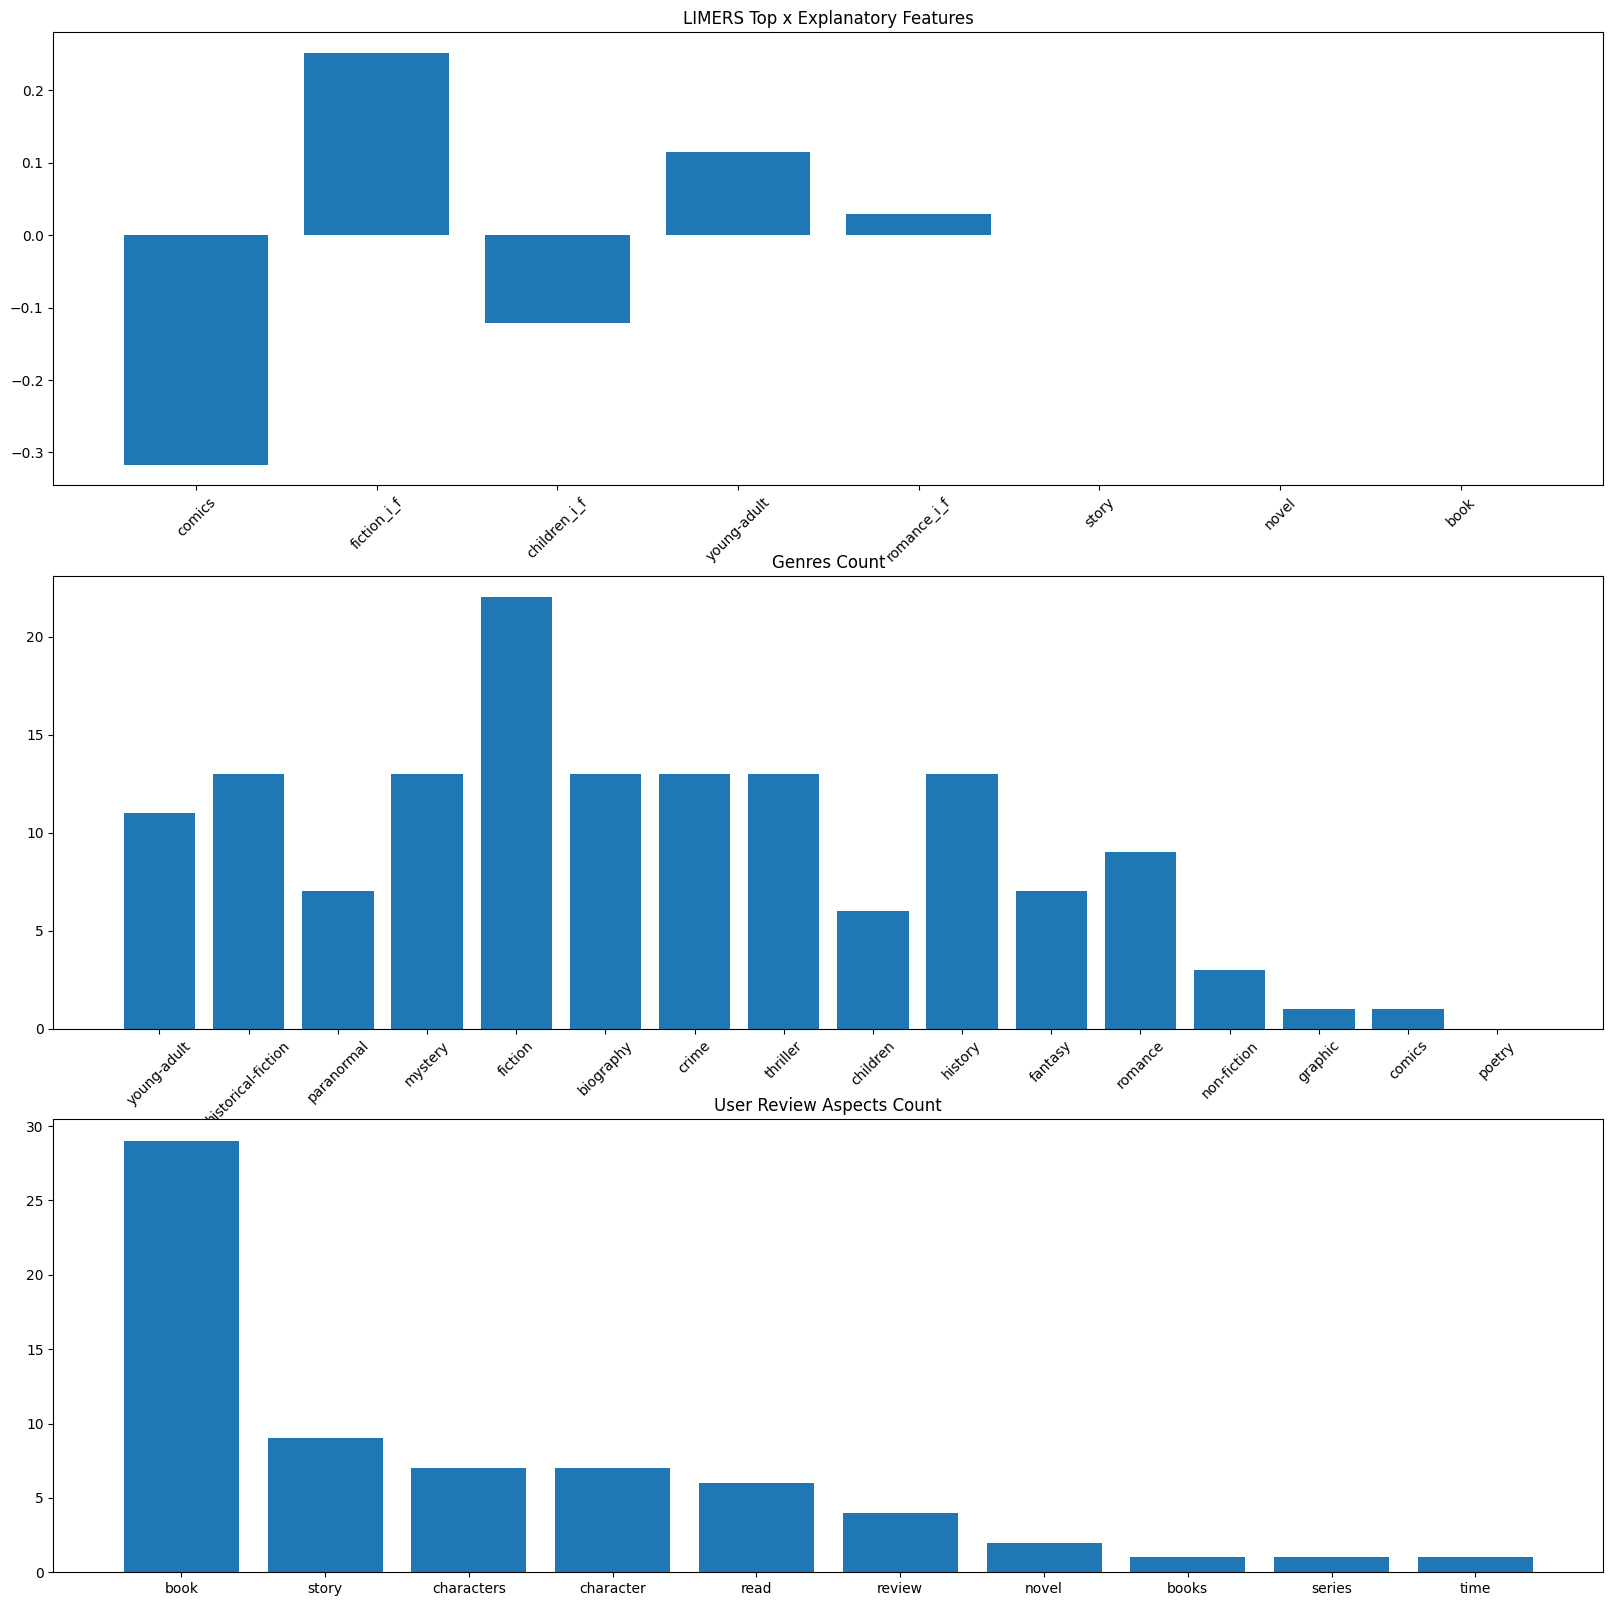

In [91]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 20))
axes[0].bar(exp.keys(), exp.values())
axes[0].set_title("LIMERS Top x Explanatory Features")
axes[1].bar(item_genres_count.keys(), item_genres_count.values())
axes[1].set_title("Genres Count")
axes[2].bar([x for (x,_) in aspect_list], [y for (_,y) in aspect_list])
axes[2].set_title("User Review Aspects Count")
axes[0].set_xticklabels(exp.keys(), rotation=45)
axes[1].set_xticklabels(item_genres_count.keys(), rotation=45)
plt.show()

**FFM and Libffm_mod utility function**

Utility function that converts [item, feature] data format to [feature:field:value] tabular format which is the data input format required by recommender model FFM.

In [45]:
user_item_rating = pd.DataFrame({
    'user_id':['100','200','200'],
    'item_id': ['1','2','1'],
    'rating':[4.5,5,4.8]
})

item_features = pd.DataFrame({
    'item_id':['2','1','1'],
    'production_year': ['2001','1990', '1990'],
    'genres': ['fiction','drama','action']
})

df = pd.merge(user_item_rating, item_features, on='item_id')
df

,user_id,item_id,rating,production_year,genres
0,100,1,4.5,1990,drama
1,100,1,4.5,1990,action
2,200,1,4.8,1990,drama
3,200,1,4.8,1990,action
4,200,2,5.0,2001,fiction


In [46]:
converter = LibffmModConverter().fit(df, col_rating='rating')
converted_df = converter.transform(df)
converted_df

/Users/yyz/Desktop/2023-explainable-recommendations/my_venv/lib/python3.9/site-packages/cornac-2.0.0-py3.9-macosx-10.9-universal2.egg/cornac/utils/libffm_mod.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x == object or np.issubdtype(x, np.integer) or x == np.float


,rating,user_id,item_id,"(production_year, 1990)","(production_year, 2001)","(genres, drama)","(genres, action)","(genres, fiction)"
0,4.5,1:1:1,2:3:1,3:5:1,3:6:0,4:7:1,4:8:1,4:9:0
1,4.8,1:2:1,2:3:1,3:5:1,3:6:0,4:7:1,4:8:1,4:9:0
2,5.0,1:2:1,2:4:1,3:5:0,3:6:1,4:7:0,4:8:0,4:9:1
